# Предварительный анализ данных и построение признаков в задачах распознавания объектов на фотографии
**Выполнила:** Волкова Кристина Владимировна

**Научный руководитель:** Коровин Дмитрий Игоревич

## Оглавление
- [Очищающие преобразования](#cleaning)
- [Изменение размера](#resize)
- [Изменение порядка цветов с RGB на BGR](#rgb2bgr)
- [Преобразование цветного изображения в серое изображение](#grayscale)
- [Обрезка изображения](#cropping)
- [Удаление шумов](#denoise)
- [Повышение разрешения](#upscale)
- [Поворот изображения](#rotating)
- [Пороговая обработка](#threshhold)
- [Edge detection](#edge-detection)

Импортируем такие библиотеки, как `numpy` и `matplotlib`. Кроме того, мы импортируем определенные функции из библиотек `skimage` и `sklearn`.

In [44]:
import skimage
import skimage.io
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma
from scipy import ndimage
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image

In [143]:
image = mpimg.imread("iu-9.jpeg")
type(image)

numpy.ndarray

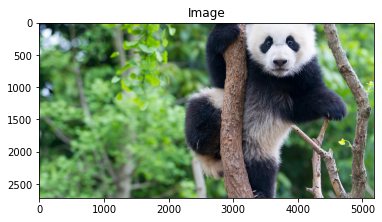

In [46]:
plt.title("Image")
plt.imshow(image)

In [70]:
print("Количество пикселей: ",image.size)
print("Размер: ",image.shape)

Количество пикселей:  42208128
Размер:  (2714, 5184, 3)


In [71]:
print("Среднее:",image.mean())
print("Макс:",image.max())
print("Минимум:",image.min())

Среднее: 103.73705393899488
Макс: 255
Минимум: 0


Обратите внимание, что дано только одно изображение панды. Изображение представляет собой трехканальное цветное изображение. С высотой равной 2714 и с шириной - 5184.

## Очищающие Преобразования <a id="cleaning"></a>

In [73]:
reshaped_image = image.reshape(image.shape[0],-1)
print("Размер: ",reshaped_image.shape)

Размер:  (2714, 15552)


**3072** — ширина исходного изображения (1024), умноженная на 3 - количество каналов

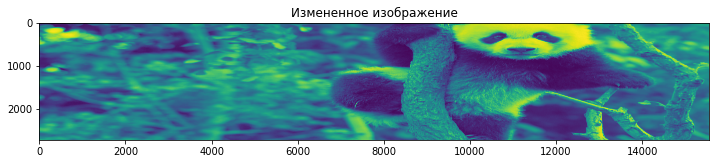

In [50]:
plt.figure(figsize = (12,12))
plt.title("Измененное изображение")
plt.imshow(reshaped_image)

## Изменение размера <a id="resize"></a>
Данные вашего изображения передаются некоторыми наборами для обучения модели. Такие серии изображений требует, чтобы все изображения в данных были одинакового размера. При обработке стоит убедиться, что все изображения, загружаемые в модель, имеют одинаковую высоту и ширину. 

In [76]:
image_resized = skimage.transform.resize(image,(300,300))

print("Количество пикселей: ",image_resized.size)
print("Размер: ",image_resized.shape)

Количество пикселей:  270000
Размер:  (300, 300, 3)


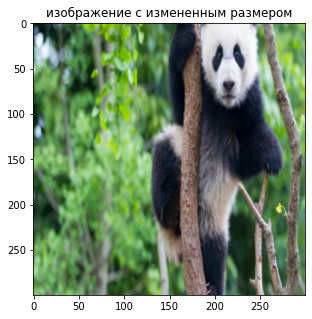

In [52]:
plt.figure(figsize=(5,5))
plt.title("изображение с измененным размером")
plt.imshow(image_resized)

### Соотношение сторон
Измененное изображение искажено, и это связано с тем, что во время изменения размера мы не сохранили соотношение сторон исходного изображения.

**Соотношение сторон изображения** — это отношение ширины изображения к высоте изображения, при этом необходимо масштабировать все изображения так, чтобы они имели одинаковое соотношение сторон для распознавания объектов. Большинство моделей предполагают, что форма входного изображения квадратная, поэтому мы должны обрезать свои изображения так, чтобы все они были квадратной формы, можно выполнить обрезку по центру, так чтобы извлечь из нее важную часть изображения.

In [53]:
# соотношение сторон = ширина/высота
aspect_ratio_original = image.shape[1]/float(image.shape[0])
aspect_ratio_resized = image_resized.shape[1]/float(image_resized.shape[0])

In [54]:
print("Изначальное соотношение сторон : ", aspect_ratio_original)
print("Измененное соотношение сторон: ", aspect_ratio_resized)

Изначальное соотношение сторон :  1.9100957995578483
Измененное соотношение сторон:  1.0


## Изменение порядка цветов с RGB на BGR <a id="rgb2bgr"></a>

In [55]:
image_BGR = image[:,:,(2,1,0)]

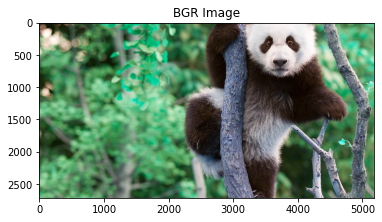

In [56]:
plt.figure(figsize=(6,6))
plt.title("BGR Image")
plt.imshow(image_BGR)

In [78]:
print("Размер: ",image_BGR.shape)

Размер:  (2714, 5184, 3)


форма осталась прежней мы только изменили порядок каналов


## Преобразование цветного изображения в серое изображение <a id="grayscale"></a>
Изображения, с которыми предстоит работать, могут быть очень большими, что означает, что мы имеете дело с объектами очень высокой размерности. Уменьшение изображений RGB до оттенков серого — это своего рода уменьшение размерности. Уменьшение размерности помогает извлечь скрытые значимые функции из базовых данных, чтобы нейронной сети не приходилось иметь дело с нерелевантными функциями.

In [159]:
image_gray = skimage.color.rgb2gray(image)

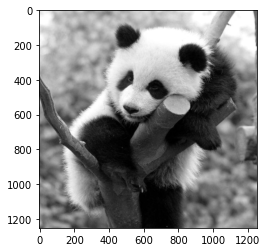

In [160]:
plt.imshow(image_gray, cmap = 'gray')

In [81]:
print("Размер: ",image_gray.shape)

Размер:  (2714, 5184)


In [61]:
print("Среднее:",image_gray.mean())
print("Макс:",image_gray.max())
print("Минимум:",image_gray.min())

Среднее: 0.4545083841769551
Макс: 1.0
Минимум: 0.0


## Обрезка изображения <a id="cropping"></a>

In [66]:
def crop(image, crop_x, crop_y):
    
    y, x, c = image.shape
    
    startx = x//2 - (crop_x // 5)
    starty = y//2 - (crop_y // 4) 
    
    stopx = startx + crop_x
    stopy = starty + 2*crop_y
    
    return image[starty:stopy, startx:stopx]

In [67]:
image_croped = crop(image,2000,5000)

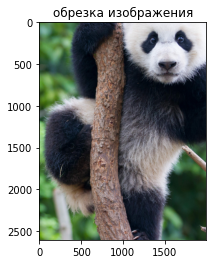

In [68]:
plt.title("обрезка изображения")
plt.imshow(image_croped)

## Удаление шумов <a id="denoise"></a>
Фильтры в основном применяются для устранения шума, размытия или сглаживания или резкости изображений. Двумя наиболее широко используемыми фильтрами являются гауссовы и медианы.

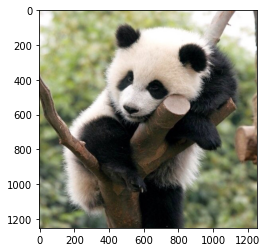

In [145]:
image = mpimg.imread("iu-8.jpeg")
plt.imshow(image)

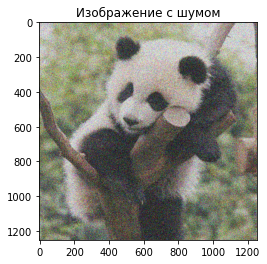

In [28]:
sigma = 0.500
image_noise = random_noise(image, var=sigma**2)
plt.title("Изображение с шумом")
plt.imshow(image_noise)

In [85]:
sigma_est = estimate_sigma(image_noise, channel_axis = 3,average_sigmas=True)
sigma_est

0.23399605962573394

### Фильтрация общей вариации
**Фильтрация общей вариации** представляет собой процесс удаления шума. В его основе лежит принцип, согласно которому сигналы с избыточной и, возможно, ложной детализацией имеют высокую общую вариацию, то есть интеграл абсолютного градиента изображения высок.

Согласно этому принципу, уменьшение общей вариации сигнала, при условии его близкого соответствия исходному сигналу, удаляет нежелательные детали, сохраняя при этом важные детали, такие как края.

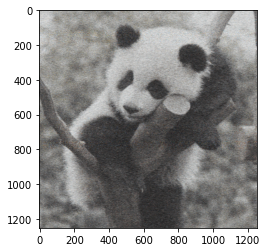

In [87]:
plt.imshow(denoise_tv_chambolle(image_noise, weight = 0.3, channel_axis = 3))

### Гауссовый фильтр
Это сохраняющий края фильтр размытия. Он усредняет пиксели на основе их пространственной близости и радиометрического сходства.

Пространственная близость измеряется гауссовой функцией евклидова расстояния между двумя пикселями и определенным стандартным отклонением `sigma_spatial`.

Радиометрическое сходство измеряется гауссовой функцией евклидова расстояния между двумя значениями цвета и определенным стандартным отклонением `sigma_color`.

/var/folders/cn/k850pvjd5kn1htsm6w6zn5zw0000gn/T/ipykernel_1420/341037158.py:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  plt.imshow(denoise_bilateral(image_noise, sigma_color = 0.1, sigma_spatial=15, multichannel = True))


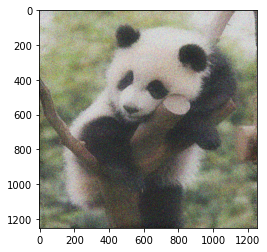

In [138]:
plt.imshow(denoise_bilateral(image_noise, sigma_color = 0.1, sigma_spatial=15, multichannel = True))

### Вейвлет-преобразование

Это разреженное представление изображения, которое можно рассматривать аналогично частотной области преобразования Фурье.

В разреженных представлениях большинство значений равны нулю или близки к нулю, и действительно случайный шум (обычно) представлен множеством малых значений в вейвлет-области. Установка всех значений ниже некоторого порога на 0 уменьшает шум в изображении, но большие пороги также уменьшают детализацию изображения.

/var/folders/cn/k850pvjd5kn1htsm6w6zn5zw0000gn/T/ipykernel_1420/3192860983.py:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  plt.imshow(denoise_wavelet(image_noise,multichannel = True))


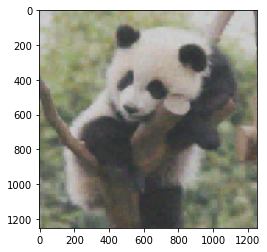

In [131]:
plt.imshow(denoise_wavelet(image_noise,multichannel = True))

### Сравнение типов удаления шума

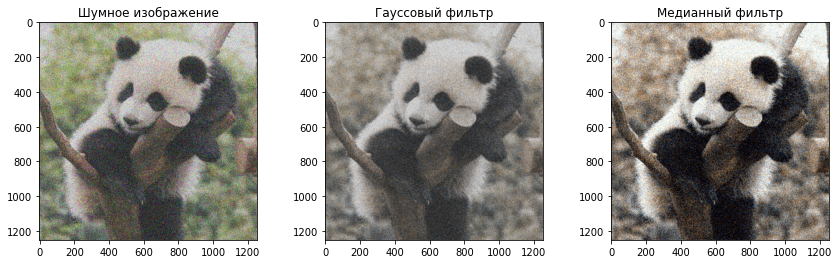

In [166]:
fig=plt.figure()

p=image[100:150,10:150]

# Добавление случайного шума к изображению
noisy_pic=p+0.7*p.std()*np.random.random(p.shape) 
ax1=fig.add_subplot(1,3,1)
ax1.imshow(image_noise)
ax1.title.set_text("Шумное изображение")

# Добавление гаусовского фильтра
gauss_pic=ndimage.gaussian_filter(image_noise,1)
ax2=fig.add_subplot(1,3,2)
ax2.imshow(gauss_pic)
ax2.title.set_text("Гауссовый фильтр")

# Добавление медианного фильтра
median_pic=ndimage.median_filter(image_noise,3)
ax3=fig.add_subplot(1,3,3)
ax3.imshow(median_pic)
ax3.title.set_text("Медианный фильтр")

plt.subplots_adjust(right=2)

### Повышение резкости
Мы видим, что изображение было размыто. Теперь давайте посмотрим, как резкость повысит качество изображения.

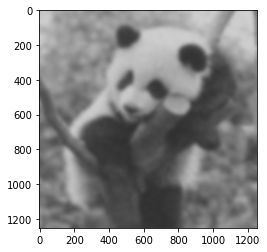

In [132]:
gauss_pic=ndimage.gaussian_filter(image_noise,10) #указание значения сигмы гаусовского фильтра как 5
plt.imshow(gauss_pic)

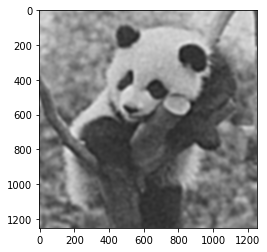

In [137]:
gauss_filter_pic=ndimage.gaussian_filter(gauss_pic,3)
sharp_pic=gauss_pic+30*(gauss_pic-gauss_filter_pic)
plt.imshow(sharp_pic)

## Повышение разрешения <a id="upscale"></a>
Его основной целью является улучшение качества изображения и, если возможно, извлечение большей информации из входного изображения.

Самый простой способ так сделать — добавить промежутки между пикселями и заполнить их, скопировав значения из ближайших пикселей. Но такое изображение не очень похоже на изображение с более высоким разрешением.

Его можно немного улучшить, взяв средние значения соседних пикселей, а не копируя ближайшие. По сути, это то, что делают алгоритм **билинейного** увеличения.

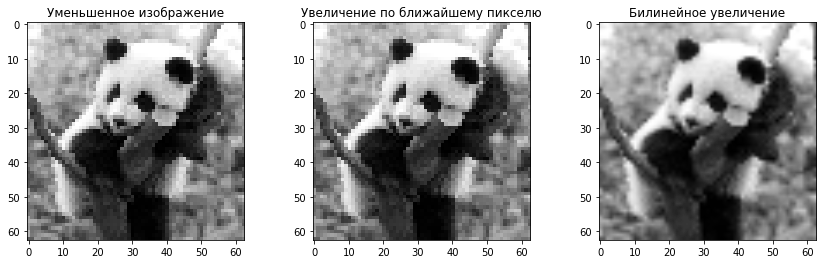

In [165]:
zoom_pic=ndimage.zoom(skimage.color.rgb2gray(image),0.05)
fig=plt.figure()

ax1=fig.add_subplot(1,3,1)
ax1.imshow(zoom_pic, cmap='gray')
ax1.title.set_text("Уменьшенное изображение")

ax2=fig.add_subplot(1,3,2)
ax2.imshow(zoom_pic,cmap=plt.cm.gray,interpolation='nearest')
ax2.title.set_text("Увеличение по ближайшему пикселю")

ax2=fig.add_subplot(1,3,3)
ax2.imshow(zoom_pic,cmap=plt.cm.gray, interpolation='bilinear')
ax2.title.set_text("Билинейное увеличение")

plt.subplots_adjust(right=2)

## Поворот изображения <a id="rotating"></a>

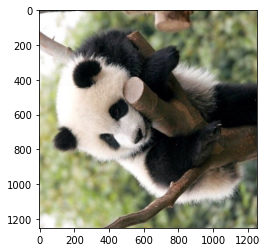

In [35]:
im = Image.open('iu-8.jpeg')
 
im_rotate = im.rotate(90)
plt.imshow(im_rotate)

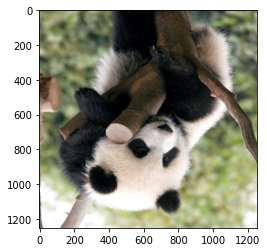

In [36]:
im_rotate2 = im.rotate(180)
plt.imshow(im_rotate2)

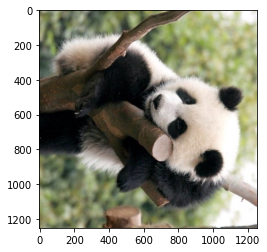

In [37]:
im_rotate3 = im.rotate(270)
plt.imshow(im_rotate3)

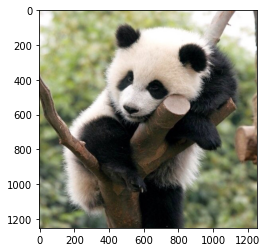

In [38]:
im_rotate3 = im.rotate(360)
plt.imshow(im_rotate3)

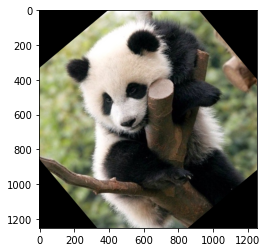

In [39]:
im_rotate3 = im.rotate(400)
plt.imshow(im_rotate3)

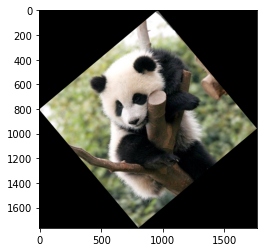

In [40]:
im_rotate4=ndimage.rotate(im,400)
plt.imshow(im_rotate4)

Мы можем видеть на изображении, что его размер изменился, чтобы соответствовать прямоугольному блоку вокруг.

## Пороговая обработка <a id="threshhold"></a>
Данная техника используется для распределения значений пикселей, проверяя границы заданного порогового значения. Все пиксели сравниваются с пороговым значением. Устанавливается в 0 те значения пикселей, которые меньше порогового значения, а если значения превышают, то устанавливается максимальное значение, обычно в 255.

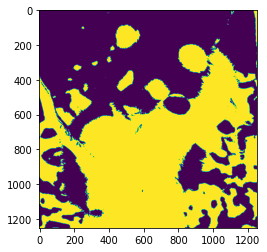

In [169]:
image = mpimg.imread("iu-8.jpeg")
a = cv2.threshold((cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(a)

## Обнаружение краев <a id="edge-detection"></a>
Для лучшего распознавания объектов на изображении нам часто нужно определить их края. Существует множество алгоритмов, используемых для этой задачи, но один из самых популярных — **Canny edge detection**.

Этот алгоритм состоит из нескольких этапов:
1. Уменьшение шума
1. Нахождение градиента интенсивности
1. Подавление не максимальных значений
1. Пороговая обработка

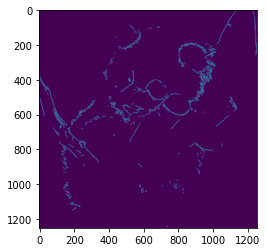

In [43]:
image = mpimg.imread("iu-8.jpeg")
b = cv2.Canny(image, 100, 200)
plt.imshow(b)

Number of Contours found = 2535


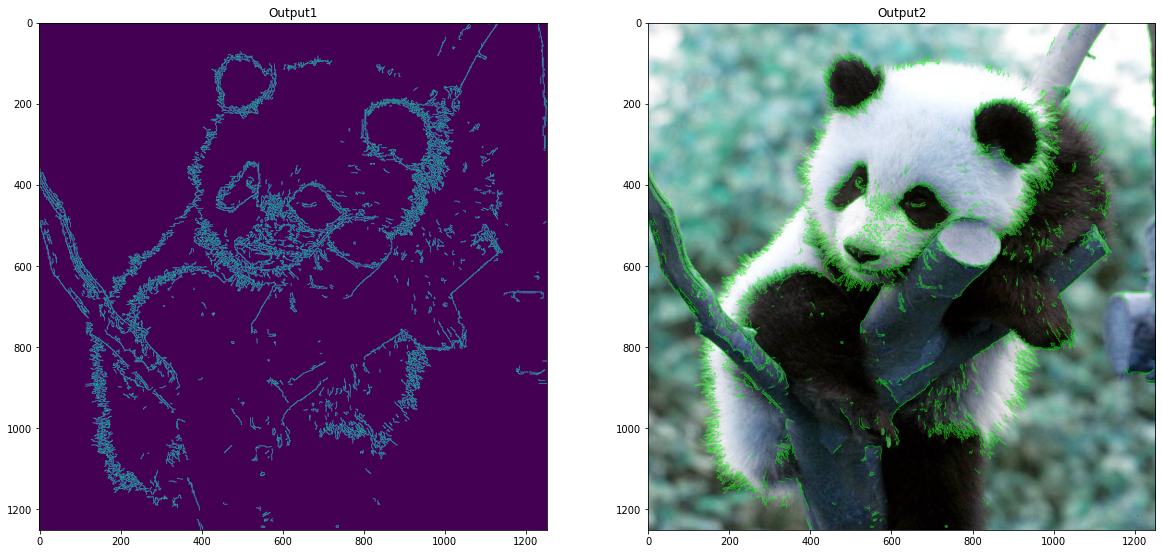

In [41]:
image = cv2.imread('iu-8.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
edge = cv2.Canny(gray, 50, 100) 

contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  
print("Number of Contours found = " + str(len(contours))) 

contour = cv2.drawContours(image, contours, -1, (0, 255, 0), 1) 

plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(edge),plt.title('Output1')
plt.subplot(122),plt.imshow(contour),plt.title('Output2')
plt.show()